In [1]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### 1. Load the preprocessed training and test datasets

In [2]:
train = pd.read_csv(r"C:\Users\YILMAZ\Desktop\train_fe.csv")
test = pd.read_csv(r"C:\Users\YILMAZ\Desktop\test_fe.csv")
# Non-scaled datasets were used 

### 2. Define features and target variable

In [3]:
target = "price_z"
X_train = train.drop(columns=[target])
y_train = train[target]

### 3. Define the objective function for Optuna

In [4]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'n_jobs': -1
    }

    # Initialize model with trial parameters
    model = XGBRegressor(**params)

    # 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = -cross_val_score(model, X_train, y_train, 
                            cv=cv, 
                            scoring='neg_root_mean_squared_error').mean()
    return rmse

### 4. Launch the hyperparameter search

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=900)  # Optional 15 min timeout

# 5. Print the best parameters
print("\n Best hyperparameters found by Optuna:")
print(study.best_params)

[I 2025-05-21 19:53:24,788] A new study created in memory with name: no-name-363d1ec2-d95b-4adc-83ed-17c9cf9dba51
[I 2025-05-21 19:53:30,743] Trial 0 finished with value: 94594.80105642861 and parameters: {'n_estimators': 170, 'max_depth': 4, 'learning_rate': 0.06416575670199413, 'subsample': 0.690288414337924, 'colsample_bytree': 0.6917864986058653, 'min_child_weight': 2, 'reg_alpha': 0.22220753493798262, 'reg_lambda': 7.6459883835408995}. Best is trial 0 with value: 94594.80105642861.
[I 2025-05-21 19:54:00,423] Trial 1 finished with value: 97194.01559935292 and parameters: {'n_estimators': 568, 'max_depth': 6, 'learning_rate': 0.005829703244844119, 'subsample': 0.5711445628849907, 'colsample_bytree': 0.8432253212814589, 'min_child_weight': 2, 'reg_alpha': 5.323933646794426, 'reg_lambda': 8.358071175417269}. Best is trial 0 with value: 94594.80105642861.
[I 2025-05-21 19:54:12,150] Trial 2 finished with value: 352330.83251583774 and parameters: {'n_estimators': 168, 'max_depth': 7, '


 Best hyperparameters found by Optuna:
{'n_estimators': 494, 'max_depth': 9, 'learning_rate': 0.021315272214132274, 'subsample': 0.9400825964853837, 'colsample_bytree': 0.7362337180733046, 'min_child_weight': 10, 'reg_alpha': 4.329999219086878, 'reg_lambda': 3.2316945044601773}


### 5. Train the best model on full training data

In [6]:
best_model = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7362337180733046, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.021315272214132274,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=494, n_jobs=-1,
             num_parallel_tree=None, ...)

### 6. Evaluate performance using 5-fold cross-validation

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = -cross_val_score(best_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
cv_mae = -cross_val_score(best_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
cv_r2 = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=cv)

print("\n Tuned XGBoost 5-Fold Cross-Validation Results:")
print(f"🔹 RMSE: {cv_rmse.mean():,.2f} ± {cv_rmse.std():,.2f}")
print(f"🔹 MAE: {cv_mae.mean():,.2f} ± {cv_mae.std():,.2f}")
print(f"🔹 R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


 Tuned XGBoost 5-Fold Cross-Validation Results:
🔹 RMSE: 93,259.95 ± 1,146.38
🔹 MAE: 67,799.14 ± 486.21
🔹 R²: 0.9530 ± 0.0007


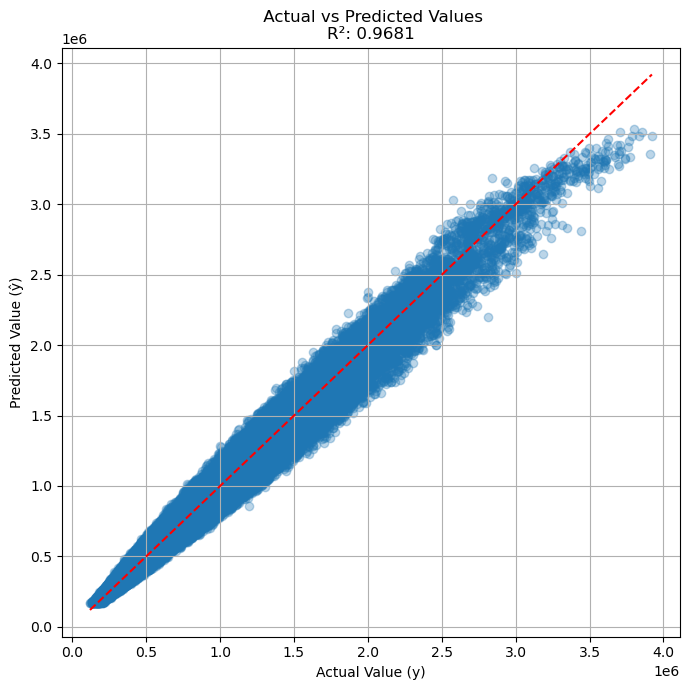

In [15]:
y_pred = best_model.predict(X_train)

plt.figure(figsize=(7, 7))
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Value (y)")
plt.ylabel("Predicted Value (ŷ)")
plt.title(f" Actual vs Predicted Values\nR²: {r2_score(y_train, y_pred):.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()

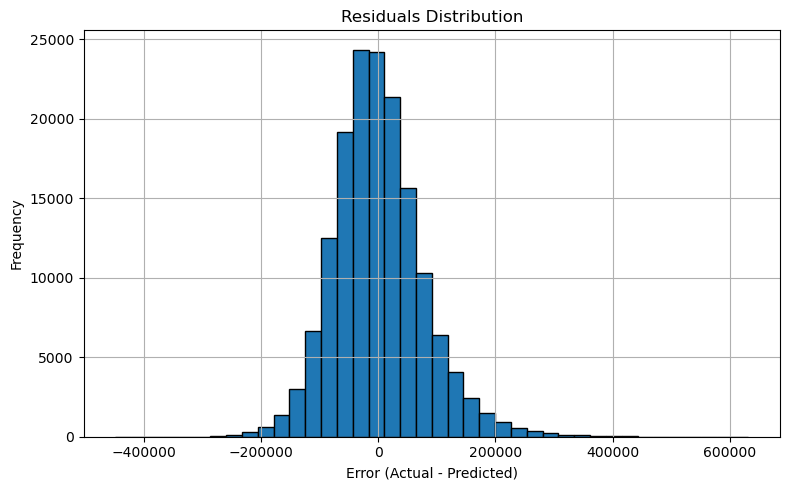

In [12]:
residuals = y_train - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=40, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

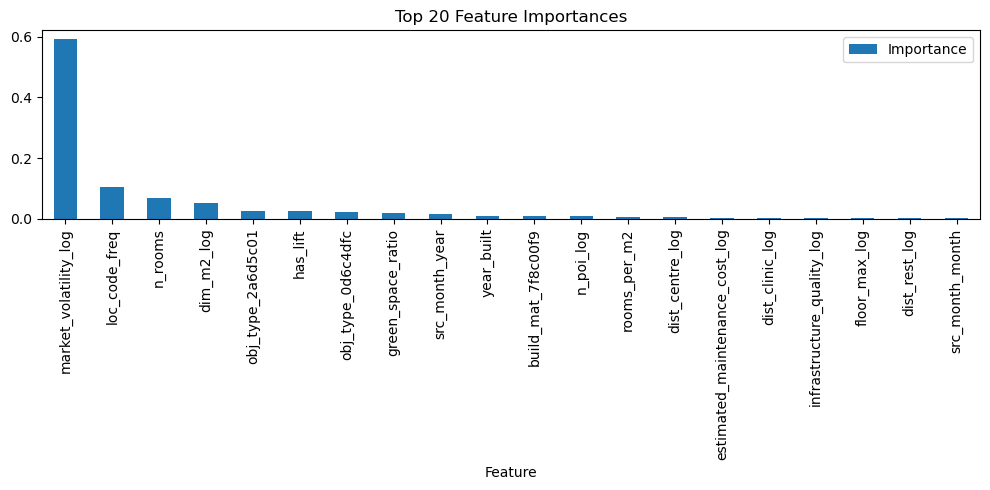

In [16]:
importances = best_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False).head(20).plot.bar(x='Feature', y='Importance', figsize=(10,5), title="Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [19]:
# 1. Prediction on test set
y_test_pred = best_model.predict(test)

# 2. Creating dataframe that includes predictions
results_df = test.copy()
results_df['price_z'] = y_test_pred

# 3. Save to CSV file
results_df.to_csv("predicted_prices.csv", index=False)